In [1]:
# ==============================================================================
# Cell 1: Setup and Configuration (WGAN-GP with Attention)
# ==============================================================================

# --- 1.1. Install necessary libraries ---
# umap-learn is added for the new downstream task visualization
# !pip install numpy scipy scikit-learn matplotlib seaborn pandas mne torch umap-learn --quiet

# --- 1.2. Imports ---
import seaborn as sns
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from scipy import signal
from scipy.linalg import sqrtm
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import umap
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# --- 1.3. Configuration & Setup ---
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Model and Data Parameters
# NOTE: Use the provided Kaggle dataset path for this file
DATA_PATH = "/kaggle/input/mpi-lemon-eeg/lemon_preprocessed_8ch_512ts.npy" 
CHANNELS = 8
TIMESTEPS = 512
LATENT_DIM = 100
NUM_CLASSES = 2 # Using dummy classes for the cGAN setup

# Training Hyperparameters for WGAN-GP
NUM_EPOCHS = 200
BATCH_SIZE = 64
LR = 1e-4
BETA1 = 0.0 # Recommended beta for WGAN-GP
BETA2 = 0.9
CRITIC_ITERATIONS = 5 # Standard for WGANs
LAMBDA_GP = 10.0 # Gradient penalty coefficient
DIVERSITY_WEIGHT = 0.1 # Mode-seeking loss weight

# Evaluation
SAVE_INTERVAL = 5

# --- Setup device ---
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print("Configuration set for ResGAN-with-Attention V6 training.")

2025-06-29 11:53:22.332104: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751198002.526982      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751198002.581698      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda
Configuration set for ResGAN-with-Attention V6 training.


In [2]:
# ==============================================================================
# Cell 2: Load and Scale Preprocessed Data (Unchanged)
# ==============================================================================

try:
    # --- 1. Load the original data ---
    data = np.load(DATA_PATH)
    print(f"Successfully loaded original data. Shape: {data.shape}")
    
    # --- 2. Keep a copy of the original data for final evaluation ---
    # This is crucial for un-scaling and fair evaluation.
    original_data_for_eval = data[:2048].copy()
    
    # --- 3. Calculate the scaling factor and apply it ---
    # This scales the data to the [-1, 1] range of the generator's Tanh activation.
    scale_factor = np.max(np.abs(data))
    data = data / scale_factor
    print(f"Data scaled by factor: {scale_factor:.4f}. New min/max: {data.min():.4f} / {data.max():.4f}")
    
    # --- 4. Create the DataLoader with the SCALED data ---
    labels = np.random.randint(0, NUM_CLASSES, data.shape[0])
    
    dataset = TensorDataset(torch.from_numpy(data).float(), torch.from_numpy(labels).long())
    dataloader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )
    print("Created DataLoader successfully with SCALED data.")
    
except FileNotFoundError:
    print(f"ERROR: Data file not found at '{DATA_PATH}'.")
    print("Please ensure the MPI-LEMON dataset is added to this Kaggle notebook.")
except Exception as e:
    print(f"An error occurred: {e}")

Successfully loaded original data. Shape: (35503, 512, 8)
Data scaled by factor: 20.0000. New min/max: -0.9318 / 1.0000
Created DataLoader successfully with SCALED data.


In [3]:
# ==============================================================================
# Cell 3: The New "ResGAN-with-Attention V6" Architectures
# ==============================================================================

from torch.nn.utils import spectral_norm

class SelfAttention(nn.Module):
    """
    Self-attention layer inspired by the Transformer architecture.
    This layer allows the model to weigh the importance of different time steps
    when constructing a representation, capturing long-range dependencies.
    """
    def __init__(self, in_channels):
        super(SelfAttention, self).__init__()
        self.in_channels = in_channels
        
        # Query, Key, Value convolutional layers
        self.query_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.key_conv = nn.Conv1d(in_channels, in_channels // 8, kernel_size=1)
        self.value_conv = nn.Conv1d(in_channels, in_channels, kernel_size=1)
        
        self.softmax = nn.Softmax(dim=-1)
        self.gamma = nn.Parameter(torch.zeros(1)) # Learnable scaling parameter

    def forward(self, x):
        batch_size, C, length = x.size()
        
        proj_query = self.query_conv(x).reshape(batch_size, -1, length).permute(0, 2, 1)
        proj_key = self.key_conv(x).reshape(batch_size, -1, length)
        energy = torch.bmm(proj_query, proj_key) # Attention scores
        
        attention = self.softmax(energy)
        proj_value = self.value_conv(x).reshape(batch_size, -1, length)
        
        out = torch.bmm(proj_value, attention.permute(0, 2, 1))
        out = out.reshape(batch_size, C, length)
        
        # Add a residual connection with learnable scaling
        out = self.gamma * out + x
        return out

# Your original ResBlock is preserved as it is excellent for local features.
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResBlock, self).__init__()
        self.conv_block = nn.Sequential(
            nn.BatchNorm1d(in_channels), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm1d(out_channels), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        )
        self.shortcut = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv1d(in_channels, out_channels, kernel_size=1)
        )
        
    def forward(self, x):
        return self.conv_block(x) + self.shortcut(x)

class ResGenerator_with_Attention(nn.Module):
    def __init__(self, latent_dim, num_classes, channels, timesteps):
        super(ResGenerator_with_Attention, self).__init__()
        self.initial_len = timesteps // 16
        self.label_emb = nn.Embedding(num_classes, latent_dim)
        self.fc = nn.Linear(latent_dim * 2, 256 * self.initial_len)
        
        self.res_block1 = ResBlock(256, 128)
        self.res_block2 = ResBlock(128, 64)
        # --- ATTENTION INSERTED HERE ---
        # Placed where features are semantically meaningful.
        self.attention = SelfAttention(64)
        self.res_block3 = ResBlock(64, 32) 
        self.res_block4 = ResBlock(32, 16)
        
        self.final_conv = nn.Sequential(
            nn.BatchNorm1d(16), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv1d(16, channels, kernel_size=3, padding=1),
            nn.Tanh() # Output is in [-1, 1]
        )
        
    def forward(self, noise, labels):
        c = self.label_emb(labels)
        x = torch.cat([noise, c], 1)
        x = self.fc(x)
        x = x.reshape(x.size(0), 256, self.initial_len)
        
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.attention(x) # Apply attention
        x = self.res_block3(x)
        x = self.res_block4(x)
        
        x = self.final_conv(x)
        return x.transpose(1, 2)

class V6InspiredDiscriminator_with_Attention(nn.Module):
    def __init__(self, num_classes, channels, timesteps):
        super(V6InspiredDiscriminator_with_Attention, self).__init__()
        self.channels = channels
        self.timesteps = timesteps
        self.embedding_size = channels * timesteps
        self.label_emb = nn.Embedding(num_classes, self.embedding_size)
        
        # --- Convolutional Layers ---
        self.conv1 = nn.Sequential(
            spectral_norm(nn.Conv1d(channels * 2, 128, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            spectral_norm(nn.Conv1d(128, 256, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True)
        )
        # --- ATTENTION INSERTED HERE ---
        self.attention = SelfAttention(256)
        self.conv3 = nn.Sequential(
            spectral_norm(nn.Conv1d(256, 512, 5, 2, 2)), 
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        # --- Dynamically calculate the size for the linear layer ---
        with torch.no_grad():
            # ==================================================================
            # THE FIX IS HERE: The dummy input shape now matches the real data
            # format (batch, timesteps, channels) before the transpose.
            # FROM: dummy_input = torch.randn(1, channels, timesteps)
            # TO:   dummy_input = torch.randn(1, timesteps, channels)
            # ==================================================================
            dummy_input = torch.randn(1, timesteps, channels)
            
            dummy_labels = torch.zeros(1, dtype=torch.long)
            # Pass through the feature extractor part to get the output size
            conv_out_size = self._get_conv_output_size(dummy_input, dummy_labels)
            
        self.classifier = nn.Sequential(
            spectral_norm(nn.Linear(conv_out_size, 1024)), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.5),
            spectral_norm(nn.Linear(1024, 1))
        )
        
    def _feature_extractor(self, eeg, labels):
        # Expects eeg in shape (batch, timesteps, channels)
        x = eeg.transpose(1, 2) # Now shape is (batch, channels, timesteps)
        
        c = self.label_emb(labels).reshape(-1, self.channels, self.timesteps)
        x = torch.cat([x, c], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.attention(x)
        x = self.conv3(x)
        return x
        
    def _get_conv_output_size(self, eeg, labels):
        out = self._feature_extractor(eeg, labels)
        return out.reshape(out.size(0), -1).size(1)
        
    def forward(self, eeg, labels):
        features = self._feature_extractor(eeg, labels)
        flat_features = features.reshape(features.size(0), -1)
        return self.classifier(flat_features)
        
print("ResGAN-with-Attention V6 architectures defined.")

ResGAN-with-Attention V6 architectures defined.


In [4]:
# ==============================================================================
# Cell 4: The Ultimate Visualization Suite (BUG FIXED & FULLY SELF-CONTAINED)
# ==============================================================================

# --- Imports required for this plotting suite ---
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA
from scipy import signal
# =================================================================
# BUG FIX: Added the missing import for cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
# =================================================================

# Your excellent plotting functions are preserved here.
def plot_figure_2(history, save_path):
    """Generates the 5-panel training statistics plot (YARE-GAN Figure 2)."""
    fig, axes = plt.subplots(3, 2, figsize=(18, 15))
    fig.delaxes(axes[2, 1])
    axes = axes.flatten()
    steps = np.arange(1, len(history['g_loss']) + 1)
    axes[0].plot(steps, history['g_loss'], label='Generator Loss', color='blue'); axes[0].set_title('Generator Loss')
    axes[1].plot(steps, history['d_loss'], label='Critic Loss', color='red'); axes[1].set_title('Critic Loss')
    axes[2].plot(steps, history['gp'], label='Gradient Penalty', color='green'); axes[2].set_title('Gradient Penalty')
    axes[3].plot(steps, history['grad_norm'], label='Critic Gradient Norm', color='purple'); axes[3].set_title('Critic Gradient Norm')
    axes[4].plot(steps, history['real_pred'], label='Real Prediction', color='blue'); axes[4].plot(steps, history['fake_pred'], label='Fake Prediction', color='orange'); axes[4].set_title('Fake and Real Prediction')
    for ax in axes[:5]: ax.legend(); ax.grid(True, linestyle='--'); ax.set_xlabel('Training Step')
    plt.tight_layout(); fig.suptitle('Training Statistics', fontsize=20, y=1.02); plt.savefig(save_path); plt.close()
    print("Generated training statistics plot (Figure 2).")

def plot_figure_3(real_data, gen_data, save_path_prefix):
    """Generates plots for Figure 3a (PCA) and 3b (Histogram)."""
    pca = PCA(n_components=2); real_flat, gen_flat = real_data.reshape(real_data.shape[0], -1), gen_data.reshape(gen_data.shape[0], -1)
    pca.fit(real_flat); real_pca, gen_pca = pca.transform(real_flat), pca.transform(gen_flat)
    plt.figure(figsize=(10, 10)); plt.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.5, label='Real EEG', s=15, c='blue'); plt.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.5, label='Generated EEG', s=15, c='orange')
    plt.title('PCA Distribution of Real vs. Generated Data', fontsize=16); plt.xlabel('PC 1', fontsize=12); plt.ylabel('PC 2', fontsize=12); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.savefig(f"{save_path_prefix}_fig3a_pca.png"); plt.close()
    plt.figure(figsize=(12, 7)); sns.histplot(real_data.flatten(), color="blue", label='Real', stat='density', bins=100, alpha=0.7); sns.histplot(gen_data.flatten(), color="orange", label='Generated', stat='density', bins=100, alpha=0.7)
    plt.title('Global Amplitude Distribution', fontsize=16); plt.xlabel('Amplitude (uV)', fontsize=12); plt.ylabel('Density', fontsize=12); plt.legend(); plt.savefig(f"{save_path_prefix}_fig3b_histogram.png"); plt.close()
    print("Generated distribution plots (PCA, Histogram - Figure 3).")

def plot_figure_4(real_data, gen_data, save_path_prefix):
    """Generates per-channel PSD and Time-Series plots."""
    channel_names = ['F1', 'F2', 'C1', 'C2', 'P1', 'P2', 'O1', 'O2']; sfreq = 98
    fig_psd, axes_psd = plt.subplots(4, 2, figsize=(18, 24), sharex=True, sharey=True)
    fig_ts, axes_ts = plt.subplots(4, 2, figsize=(18, 12), sharex=True, sharey=True)
    axes_psd, axes_ts = axes_psd.flatten(), axes_ts.flatten(); time_axis = np.arange(real_data.shape[1]) / sfreq
    for i in range(real_data.shape[2]):
        f_real, psd_real = signal.welch(real_data[:, :, i], fs=sfreq, axis=1, nperseg=sfreq*2); f_gen, psd_gen = signal.welch(gen_data[:, :, i], fs=sfreq, axis=1, nperseg=sfreq*2)
        mean_psd_real, std_psd_real = np.mean(np.log10(psd_real + 1e-12), 0), np.std(np.log10(psd_real + 1e-12), 0)
        mean_psd_gen, std_psd_gen = np.mean(np.log10(psd_gen + 1e-12), 0), np.std(np.log10(psd_gen + 1e-12), 0)
        axes_psd[i].plot(f_real, mean_psd_real, label='Real', color='blue'); axes_psd[i].fill_between(f_real, mean_psd_real - std_psd_real, mean_psd_real + std_psd_real, color='blue', alpha=0.2)
        axes_psd[i].plot(f_gen, mean_psd_gen, label='Generated', color='orange'); axes_psd[i].fill_between(f_gen, mean_psd_gen - std_psd_gen, mean_psd_gen + std_psd_gen, color='orange', alpha=0.2)
        axes_psd[i].set_title(f'Channel: {channel_names[i]}'); axes_psd[i].set_xlabel('Frequency (Hz)'); axes_psd[i].set_ylabel('Log Power/Hz'); axes_psd[i].legend(); axes_psd[i].grid(True, linestyle='--'); axes_psd[i].set_xlim(0, 45)
        axes_ts[i].plot(time_axis, real_data[0, :, i], label='Real', color='blue', alpha=0.8); axes_ts[i].plot(time_axis, gen_data[0, :, i], label='Generated', color='orange', alpha=0.8)
        axes_ts[i].set_title(f'Channel: {channel_names[i]}'); axes_ts[i].set_xlabel('Time (s)'); axes_ts[i].set_ylabel('Amplitude (uV)'); axes_ts[i].legend()
    fig_psd.tight_layout(); fig_psd.savefig(f"{save_path_prefix}_fig4_psd.png"); plt.close(fig_psd)
    fig_ts.tight_layout(); fig_ts.savefig(f"{save_path_prefix}_fig4_timeseries.png"); plt.close(fig_ts)
    print("Generated PSD and Time-Series plots (Figure 4).")

def plot_figure_5(real_data, gen_data, save_path_prefix):
    """Generates functional connectivity plots."""
    real_flat = real_data.reshape(-1, real_data.shape[2]); gen_flat = gen_data.reshape(-1, gen_data.shape[2])
    conn_real = cosine_similarity(real_flat.T); conn_gen = cosine_similarity(gen_flat.T)
    fig, axes = plt.subplots(1, 2, figsize=(18, 8))
    sns.heatmap(conn_real, ax=axes[0], annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1); axes[0].set_title('Real EEG Connectivity', fontsize=16)
    sns.heatmap(conn_gen, ax=axes[1], annot=True, fmt='.2f', cmap='viridis', vmin=0, vmax=1); axes[1].set_title('Generated EEG Connectivity', fontsize=16)
    fig.suptitle('Functional Connectivity Comparison', fontsize=20); plt.savefig(f"{save_path_prefix}_fig5_connectivity.png"); plt.close()
    print("Generated connectivity plots (Figure 5).")

def plot_figure_6_detailed(fd_history, save_interval, save_path):
    """Generates the detailed, multi-panel Fréchet Distance plots."""
    epochs = (np.arange(len(fd_history)) + 1) * save_interval
    spectral_keys = ['FD delta', 'FD theta', 'FD alpha', 'FD beta', 'FD gamma']; time_keys = ['FD skewness', 'FD kurtosis', 'FD complexity', 'FD mobility', 'FD activity']
    fig, axes = plt.subplots(2, 5, figsize=(25, 10), sharex=True)
    for i, key in enumerate(spectral_keys): axes[0, i].plot(epochs, [d[key] for d in fd_history], '-o'); axes[0, i].set_title(key.replace('FD ', '').capitalize()); axes[0, i].grid(True, linestyle='--')
    for i, key in enumerate(time_keys): axes[1, i].plot(epochs, [d[key] for d in fd_history], '-o'); axes[1, i].set_title(key.replace('FD ', '').capitalize()); axes[1, i].grid(True, linestyle='--'); axes[1, i].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Fréchet Distance'); axes[1, 0].set_ylabel('Fréchet Distance'); fig.suptitle('Detailed Fréchet Distance Progression Over Training', fontsize=22); plt.savefig(save_path); plt.close()
    print("Generated detailed FD progression plot (Figure 6).")

def plot_figure_12_pca_progression(pca_history, save_path):
    """Plots the progression of the PCA distribution over training."""
    num_plots = len(pca_history); cols = min(num_plots, 5); rows = (num_plots + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5), sharex=True, sharey=True)
    if rows == 1: axes = axes.reshape(1, -1)
    axes = axes.flatten()
    for i, data in enumerate(pca_history):
        epoch, real_pca, gen_pca = data; ax = axes[i]
        ax.scatter(real_pca[:, 0], real_pca[:, 1], alpha=0.3, s=10, c='blue', label='Real'); ax.scatter(gen_pca[:, 0], gen_pca[:, 1], alpha=0.3, s=10, c='orange', label='Generated')
        ax.set_title(f'Epoch {epoch}'); ax.set_xlim(-35, 35); ax.set_ylim(-35, 35); ax.grid(True, linestyle='--')
    for j in range(i + 1, len(axes)): axes[j].set_visible(False)
    fig.suptitle("Progression of PCA Distribution Over Training", fontsize=20); plt.tight_layout(rect=[0, 0, 1, 0.96]); plt.savefig(save_path); plt.close()
    print("Generated PCA progression plot (Figure 12).")


def run_final_evaluation_and_plotting(output_dir, device, scale_factor, original_data_for_eval):
    """
    Loads the best saved generator, produces un-scaled samples, and generates
    all final paper-quality figures.
    """
    print("\n--- Final Model Analysis & Visualization ---")
    
    try:
        best_generator = ResGenerator_with_Attention(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
        best_generator.load_state_dict(torch.load(os.path.join(output_dir, 'generator_best_attention_v6.pth')))
        best_generator.eval()

        with torch.no_grad():
            z_final = torch.randn(original_data_for_eval.shape[0], LATENT_DIM, device=device)
            labels_final = torch.randint(0, NUM_CLASSES, (original_data_for_eval.shape[0],), device=device)
            generated_samples_scaled = best_generator(z_final, labels_final).cpu().numpy()
            final_generated_samples = generated_samples_scaled * scale_factor
            print("Generated samples have been correctly un-scaled for final analysis.")

        plot_prefix = os.path.join(output_dir, "Final_AttentionV6_")
        plot_figure_3(original_data_for_eval, final_generated_samples, plot_prefix)
        plot_figure_4(original_data_for_eval, final_generated_samples, plot_prefix)
        plot_figure_5(original_data_for_eval, final_generated_samples, plot_prefix)
        print(f"\nAll final evaluation plots saved to the output directory.")

    except FileNotFoundError:
        print("ERROR: Best model ('generator_best_attention_v6.pth') not found. Cannot generate final plots.")
    except Exception as e:
        print(f"An error occurred during final evaluation: {e}")

print("Ultimate evaluation suite defined and bug-fixed.")

Ultimate evaluation suite defined and bug-fixed.


In [5]:
# ==============================================================================
# Cell 5: The WGAN-GP Training Loop (for ResGAN-with-Attention V6)
# ==============================================================================

# --- Helper Functions for Detailed FD Calculation (Preserved from original) ---
def get_detailed_features(data, sfreq=98):
    from scipy.stats import skew, kurtosis
    data_t = data.transpose(0, 2, 1) # (N, C, T)
    bands = {'delta': (0.5, 4), 'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30), 'gamma': (30, 45)}
    freqs, psd = signal.welch(data_t, fs=sfreq, axis=2, nperseg=sfreq*2)
    spectral_features = {f'FD {b}': np.mean(psd[:, :, np.logical_and(freqs >= r[0], freqs <= r[1])], axis=2) for b, r in bands.items()}
    dx = np.diff(data_t, axis=2); var_x, var_dx = np.var(data_t, axis=2), np.var(dx, axis=2)
    activity = var_x; mobility = np.sqrt(var_dx / (var_x + 1e-8)); 
    complexity = np.sqrt(np.var(np.diff(dx, axis=2), axis=2) / (var_dx + 1e-8)) / (mobility + 1e-8)
    time_features = {'FD activity': activity, 'FD mobility': mobility, 'FD complexity': complexity, 'FD skewness': skew(data_t, axis=2), 'FD kurtosis': kurtosis(data_t, axis=2)}
    return {**spectral_features, **time_features}

def calculate_detailed_frechet_distance(real_features, gen_features):
    scores = {}
    for key in real_features.keys():
        mu1, sigma1 = np.mean(real_features[key], axis=0), np.cov(real_features[key], rowvar=False)
        mu2, sigma2 = np.mean(gen_features[key], axis=0), np.cov(gen_features[key], rowvar=False)
        ssdiff = np.sum((mu1 - mu2)**2.0)
        covmean = sqrtm(sigma1.dot(sigma2))
        if np.iscomplexobj(covmean): covmean = covmean.real
        fd = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
        scores[key] = fd if not np.isnan(fd) else 1e6
    return scores

def compute_gradient_penalty(discriminator, real_samples, fake_samples, labels, device):
    alpha = torch.rand(real_samples.size(0), 1, 1, device=device)
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = discriminator(interpolates, labels)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates, grad_outputs=torch.ones(d_interpolates.size(), device=device), create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.reshape(gradients.size(0), -1)
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

# --- Model and Optimizer Setup using NEW Architectures ---
generator = ResGenerator_with_Attention(LATENT_DIM, NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
discriminator = V6InspiredDiscriminator_with_Attention(NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
g_optimizer = optim.Adam(generator.parameters(), lr=LR, betas=(BETA1, BETA2))
d_optimizer = optim.Adam(discriminator.parameters(), lr=LR, betas=(BETA1, BETA2))

# --- Training State Storage ---
training_history = {'d_loss': [], 'g_loss': [], 'gp': [], 'grad_norm': [], 'real_pred': [], 'fake_pred': []}
detailed_fd_history = []; pca_history = []; best_fd = float('inf')
real_samples_for_eval = original_data_for_eval[:256] 

print(f"Starting WGAN-GP training for {NUM_EPOCHS} epochs with Attention V6 models...");
for epoch in range(NUM_EPOCHS):
    pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")
    for i, (real_eegs, labels) in enumerate(pbar):
        real_eegs, labels = real_eegs.to(device), labels.to(device)
        d_optimizer.zero_grad()
        z = torch.randn(real_eegs.size(0), LATENT_DIM, device=device)
        fake_eegs = generator(z, labels).detach()
        real_validity = discriminator(real_eegs, labels)
        fake_validity = discriminator(fake_eegs, labels)
        gradient_penalty = compute_gradient_penalty(discriminator, real_eegs.data, fake_eegs.data, labels.data, device)
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + LAMBDA_GP * gradient_penalty
        d_loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(discriminator.parameters(), float('inf'))
        d_optimizer.step()
        
        if i % CRITIC_ITERATIONS == 0:
            g_optimizer.zero_grad()
            z1 = torch.randn(real_eegs.size(0), LATENT_DIM, device=device); z2 = torch.randn(real_eegs.size(0), LATENT_DIM, device=device)
            gen_labels = torch.randint(0, NUM_CLASSES, (real_eegs.size(0),), device=device)
            fake_eegs1 = generator(z1, gen_labels); fake_eegs2 = generator(z2, gen_labels)
            g_loss_adv = -torch.mean(discriminator(fake_eegs1, gen_labels))
            lz = torch.mean(torch.abs(z1 - z2)); lf = torch.mean(torch.abs(fake_eegs1 - fake_eegs2))
            g_loss_div = DIVERSITY_WEIGHT * (lz / (lf + 1e-8))
            g_loss = g_loss_adv + g_loss_div
            g_loss.backward()
            g_optimizer.step()

            training_history['d_loss'].append(d_loss.item()); training_history['g_loss'].append(g_loss.item()); training_history['gp'].append(gradient_penalty.item())
            training_history['grad_norm'].append(grad_norm.item()); training_history['real_pred'].append(real_validity.mean().item()); training_history['fake_pred'].append(fake_validity.mean().item())
            pbar.set_postfix({'D Loss': f'{d_loss.item():.4f}', 'G Loss': f'{g_loss.item():.4f}'})

    # --- Epoch End Evaluation ---
    if (epoch + 1) % SAVE_INTERVAL == 0 or epoch == NUM_EPOCHS - 1:
        print(f"\n--- Epoch {epoch+1} Evaluation ---")
        generator.eval()
        with torch.no_grad():
            z_eval = torch.randn(real_samples_for_eval.shape[0], LATENT_DIM, device=device); labels_eval = torch.randint(0, NUM_CLASSES, (real_samples_for_eval.shape[0],), device=device)
            generated_samples_unscaled = generator(z_eval, labels_eval).cpu().numpy() * scale_factor
        real_feats = get_detailed_features(real_samples_for_eval); gen_feats = get_detailed_features(generated_samples_unscaled)
        fd_scores = calculate_detailed_frechet_distance(real_feats, gen_feats); detailed_fd_history.append(fd_scores)
        total_fd = np.mean(list(fd_scores.values()))
        print(f"  FD Scores - Alpha: {fd_scores['FD alpha']:.4f}, Activity: {fd_scores['FD activity']:.4f}, Mean FD: {total_fd:.4f}")
        if total_fd < best_fd:
            best_fd = total_fd
            torch.save(generator.state_dict(), os.path.join(OUTPUT_DIR, 'generator_best_attention_v6.pth'))
            torch.save(discriminator.state_dict(), os.path.join(OUTPUT_DIR, 'discriminator_best_attention_v6.pth'))
            print(f"  >>> New best model saved with Mean FD: {best_fd:.4f}")
        pca = PCA(n_components=2); real_flat = real_samples_for_eval.reshape(real_samples_for_eval.shape[0], -1); gen_flat = generated_samples_unscaled.reshape(generated_samples_unscaled.shape[0], -1)
        pca.fit(real_flat); real_pca, gen_pca = pca.transform(real_flat), pca.transform(gen_flat); pca_history.append((epoch + 1, real_pca, gen_pca))
        generator.train()

# --- Final Steps ---
print("\nTraining complete.")
plot_figure_2(training_history, os.path.join(OUTPUT_DIR, 'final_fig2_training_stats_attention_v6.png'))
plot_figure_6_detailed(detailed_fd_history, SAVE_INTERVAL, os.path.join(OUTPUT_DIR, 'final_fig6_fd_progression_attention_v6.png'))
plot_figure_12_pca_progression(pca_history, os.path.join(OUTPUT_DIR, 'final_fig12_pca_progression_attention_v6.png'))
print("Final progress plots saved.")

# --- Run the bug-fixed final evaluation using the best model ---
if 'scale_factor' in locals() and 'original_data_for_eval' in locals():
    run_final_evaluation_and_plotting(OUTPUT_DIR, device, scale_factor, original_data_for_eval)
else:
    print("Could not run final evaluation as scale_factor or original_data_for_eval were not defined.")

Starting WGAN-GP training for 200 epochs with Attention V6 models...


Epoch 1/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 2/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 3/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 4/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 5/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 5 Evaluation ---
  FD Scores - Alpha: 0.0084, Activity: 3.1558, Mean FD: 1.1760
  >>> New best model saved with Mean FD: 1.1760


Epoch 6/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 7/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 8/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 9/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 10/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 10 Evaluation ---
  FD Scores - Alpha: 0.0045, Activity: 0.7317, Mean FD: 0.4194
  >>> New best model saved with Mean FD: 0.4194


Epoch 11/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 12/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 13/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 14/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 15/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 15 Evaluation ---
  FD Scores - Alpha: 0.0030, Activity: 0.3904, Mean FD: 0.3557
  >>> New best model saved with Mean FD: 0.3557


Epoch 16/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 17/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 18/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 19/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 20/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 20 Evaluation ---
  FD Scores - Alpha: 0.0044, Activity: 0.2791, Mean FD: 0.3956


Epoch 21/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 22/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 23/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 24/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 25/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 25 Evaluation ---
  FD Scores - Alpha: 0.0031, Activity: 0.2817, Mean FD: 0.4039


Epoch 26/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 27/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 28/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 29/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 30/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 30 Evaluation ---
  FD Scores - Alpha: 0.0024, Activity: 0.2196, Mean FD: 0.3416
  >>> New best model saved with Mean FD: 0.3416


Epoch 31/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 32/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 33/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 34/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 35/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 35 Evaluation ---
  FD Scores - Alpha: 0.0024, Activity: 0.2388, Mean FD: 0.3184
  >>> New best model saved with Mean FD: 0.3184


Epoch 36/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 37/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 38/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 39/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 40/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 40 Evaluation ---
  FD Scores - Alpha: 0.0025, Activity: 0.2286, Mean FD: 0.3061
  >>> New best model saved with Mean FD: 0.3061


Epoch 41/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 42/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 43/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 44/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 45/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 45 Evaluation ---
  FD Scores - Alpha: 0.0029, Activity: 0.2147, Mean FD: 0.3544


Epoch 46/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 47/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 48/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 49/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 50/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 50 Evaluation ---
  FD Scores - Alpha: 0.0024, Activity: 0.2219, Mean FD: 0.3045
  >>> New best model saved with Mean FD: 0.3045


Epoch 51/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 52/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 53/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 54/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 55/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 55 Evaluation ---
  FD Scores - Alpha: 0.0027, Activity: 0.2278, Mean FD: 0.2943
  >>> New best model saved with Mean FD: 0.2943


Epoch 56/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 57/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 58/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 59/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 60/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 60 Evaluation ---
  FD Scores - Alpha: 0.0032, Activity: 0.2555, Mean FD: 0.3301


Epoch 61/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 62/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 63/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 64/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 65/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 65 Evaluation ---
  FD Scores - Alpha: 0.0029, Activity: 0.2660, Mean FD: 0.3157


Epoch 66/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 67/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 68/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 69/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 70/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 70 Evaluation ---
  FD Scores - Alpha: 0.0021, Activity: 0.2044, Mean FD: 0.2491
  >>> New best model saved with Mean FD: 0.2491


Epoch 71/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 72/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 73/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 74/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 75/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 75 Evaluation ---
  FD Scores - Alpha: 0.0019, Activity: 0.1914, Mean FD: 0.2262
  >>> New best model saved with Mean FD: 0.2262


Epoch 76/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 77/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 78/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 79/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 80/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 80 Evaluation ---
  FD Scores - Alpha: 0.0032, Activity: 0.2266, Mean FD: 0.3317


Epoch 81/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 82/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 83/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 84/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 85/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 85 Evaluation ---
  FD Scores - Alpha: 0.0072, Activity: 0.3194, Mean FD: 0.3058


Epoch 86/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 87/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 88/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 89/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 90/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 90 Evaluation ---
  FD Scores - Alpha: 0.0056, Activity: 0.2685, Mean FD: 0.2895


Epoch 91/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 92/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 93/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 94/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 95/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 95 Evaluation ---
  FD Scores - Alpha: 0.0022, Activity: 0.2152, Mean FD: 0.3083


Epoch 96/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 97/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 98/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 99/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 100/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 100 Evaluation ---
  FD Scores - Alpha: 0.0021, Activity: 0.2485, Mean FD: 0.3052


Epoch 101/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 102/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 103/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 104/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 105/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 105 Evaluation ---
  FD Scores - Alpha: 0.0031, Activity: 0.2420, Mean FD: 0.3716


Epoch 106/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 107/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 108/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 109/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 110/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 110 Evaluation ---
  FD Scores - Alpha: 0.0064, Activity: 0.2681, Mean FD: 0.3554


Epoch 111/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 112/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 113/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 114/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 115/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 115 Evaluation ---
  FD Scores - Alpha: 0.0143, Activity: 0.8841, Mean FD: 0.4078


Epoch 116/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 117/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 118/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 119/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 120/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 120 Evaluation ---
  FD Scores - Alpha: 0.0127, Activity: 1.0122, Mean FD: 0.5080


Epoch 121/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 122/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 123/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 124/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 125/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 125 Evaluation ---
  FD Scores - Alpha: 0.0033, Activity: 0.3804, Mean FD: 0.4044


Epoch 126/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 127/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 128/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 129/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 130/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 130 Evaluation ---
  FD Scores - Alpha: 0.2278, Activity: 25.6583, Mean FD: 2.8527


Epoch 131/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 132/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 133/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 134/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 135/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 135 Evaluation ---
  FD Scores - Alpha: 0.0185, Activity: 5.3097, Mean FD: 0.9962


Epoch 136/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 137/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 138/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 139/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 140/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 140 Evaluation ---
  FD Scores - Alpha: 0.0041, Activity: 0.2709, Mean FD: 0.2367


Epoch 141/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 142/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 143/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 144/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 145/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 145 Evaluation ---
  FD Scores - Alpha: 0.0056, Activity: 0.4577, Mean FD: 0.3391


Epoch 146/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 147/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 148/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 149/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 150/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 150 Evaluation ---
  FD Scores - Alpha: 0.0028, Activity: 0.2724, Mean FD: 0.3542


Epoch 151/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 152/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 153/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 154/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 155/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 155 Evaluation ---
  FD Scores - Alpha: 0.0020, Activity: 0.2557, Mean FD: 0.4098


Epoch 156/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 157/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 158/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 159/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 160/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 160 Evaluation ---
  FD Scores - Alpha: 0.0078, Activity: 0.3215, Mean FD: 0.4104


Epoch 161/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 162/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 163/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 164/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 165/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 165 Evaluation ---
  FD Scores - Alpha: 0.0057, Activity: 0.3378, Mean FD: 0.3786


Epoch 166/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 167/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 168/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 169/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 170/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 170 Evaluation ---
  FD Scores - Alpha: 0.0035, Activity: 0.2566, Mean FD: 0.4493


Epoch 171/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 172/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 173/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 174/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 175/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 175 Evaluation ---
  FD Scores - Alpha: 0.3526, Activity: 44.3647, Mean FD: 4.9337


Epoch 176/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 177/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 178/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 179/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 180/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 180 Evaluation ---
  FD Scores - Alpha: 0.0078, Activity: 0.3653, Mean FD: 0.4936


Epoch 181/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 182/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 183/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 184/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 185/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 185 Evaluation ---
  FD Scores - Alpha: 0.0089, Activity: 0.2620, Mean FD: 0.5012


Epoch 186/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 187/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 188/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 189/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 190/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 190 Evaluation ---
  FD Scores - Alpha: 0.0024, Activity: 0.2379, Mean FD: 0.4338


Epoch 191/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 192/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 193/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 194/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 195/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 195 Evaluation ---
  FD Scores - Alpha: 0.0264, Activity: 0.7927, Mean FD: 0.5025


Epoch 196/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 197/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 198/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 199/200:   0%|          | 0/555 [00:00<?, ?it/s]

Epoch 200/200:   0%|          | 0/555 [00:00<?, ?it/s]


--- Epoch 200 Evaluation ---
  FD Scores - Alpha: 0.0167, Activity: 0.5825, Mean FD: 0.4534

Training complete.
Generated training statistics plot (Figure 2).
Generated detailed FD progression plot (Figure 6).
Generated PCA progression plot (Figure 12).
Final progress plots saved.

--- Final Model Analysis & Visualization ---
Generated samples have been correctly un-scaled for final analysis.
Generated distribution plots (PCA, Histogram - Figure 3).
Generated PSD and Time-Series plots (Figure 4).
Generated connectivity plots (Figure 5).

All final evaluation plots saved to the output directory.



--- Starting Downstream Task on Filtered Healthy Controls ---
Loading data from: /kaggle/input/man-and-woman-classification-eeg/classification_data_full_with_ids.npz
Loaded full data. X shape: (13463, 512, 19)
Filtered for Healthy Controls. New X shape: (4662, 512, 19)
Balanced Healthy Controls by gender. Final X shape: (3472, 512, 19), y shape: (3472,)
Final gender counts: [1736 1736]
Selected 8 channels. Final X shape for GAN: (3472, 512, 8)
Extracting features from the filtered, balanced, healthy dataset...


Feature Extraction:   0%|          | 0/28 [00:00<?, ?it/s]

Generating UMAP plot for Healthy Controls...


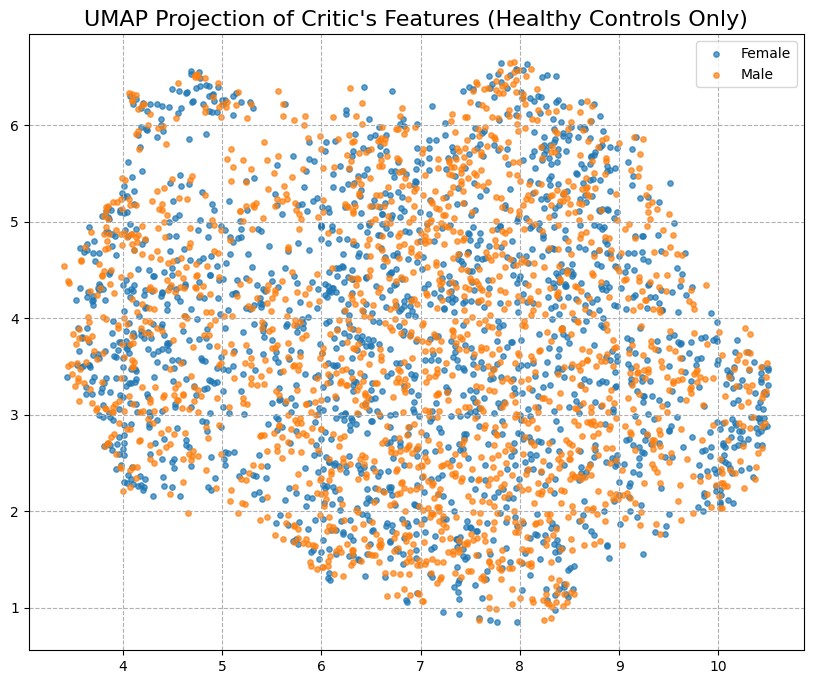


--- Downstream Task Final Results (Healthy Controls Only) ---
  > Validation Accuracy: 0.5634
              precision    recall  f1-score   support

      Female       0.56      0.58      0.57       434
        Male       0.57      0.55      0.56       434

    accuracy                           0.56       868
   macro avg       0.56      0.56      0.56       868
weighted avg       0.56      0.56      0.56       868



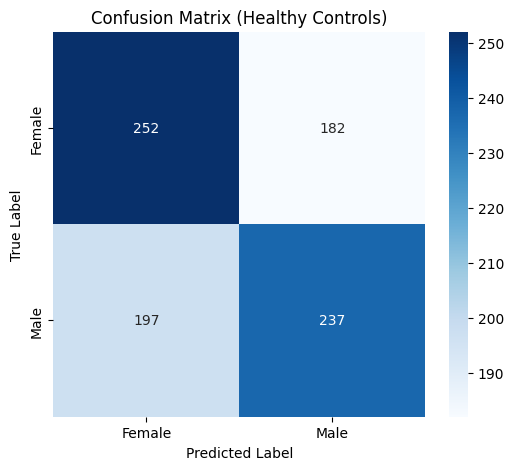

In [6]:
# ==============================================================================
# Cell 6: Downstream Task - Representation Analysis and Classification
# (FINAL VERSION - Requires new NPZ file)
# ==============================================================================
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import umap
import seaborn as sns

# --- Configuration ---
# UPDATE THIS PATH to your new NPZ file
DSTREAM_NPZ_PATH = "/kaggle/input/man-and-woman-classification-eeg/classification_data_full_with_ids.npz"

def run_downstream_classification_filtered(output_dir, device):
    print("\n--- Starting Downstream Task on Filtered Healthy Controls ---")
    
    # --- 1. Load Data with Subject and Group IDs ---
    try:
        print(f"Loading data from: {DSTREAM_NPZ_PATH}")
        data_file = np.load(DSTREAM_NPZ_PATH)
        X_full = data_file['X']
        y_gender_full = data_file['y_gender']
        y_group_full = data_file['y_group']
        print(f"Loaded full data. X shape: {X_full.shape}")
    except Exception as e:
        print(f"Could not load new NPZ file. Please ensure you ran the corrected preprocessing. Error: {e}")
        return

    # --- 2. Filter for Healthy Controls (CN) ---
    # Group map: {'A': 0, 'F': 1, 'C': 2}
    healthy_mask = (y_group_full == 2)
    X_healthy = X_full[healthy_mask]
    y_gender_healthy = y_gender_full[healthy_mask]

    print(f"Filtered for Healthy Controls. New X shape: {X_healthy.shape}")
    
    # --- 3. Balance the Healthy Control group by gender ---
    labels, counts = np.unique(y_gender_healthy, return_counts=True)
    min_count = np.min(counts)
    
    X_balanced_list, y_balanced_list = [], []
    for label in labels:
        idx = np.where(y_gender_healthy == label)[0]
        random_indices = np.random.choice(idx, min_count, replace=False)
        X_balanced_list.append(X_healthy[random_indices])
        y_balanced_list.append(y_gender_healthy[random_indices])
        
    X = np.concatenate(X_balanced_list, axis=0)
    y = np.concatenate(y_balanced_list, axis=0)

    print(f"Balanced Healthy Controls by gender. Final X shape: {X.shape}, y shape: {y.shape}")
    print(f"Final gender counts: {np.unique(y, return_counts=True)[1]}")

    # --- 4. Select correct channels ---
    X = X[:, :, :CHANNELS]
    print(f"Selected {CHANNELS} channels. Final X shape for GAN: {X.shape}")

    # --- 5. Load Critic and Extract Features (same as before) ---
    try:
        critic = V6InspiredDiscriminator_with_Attention(NUM_CLASSES, CHANNELS, TIMESTEPS).to(device)
        critic.load_state_dict(torch.load(os.path.join(output_dir, 'discriminator_best_attention_v6.pth')))
        critic.eval()
        for param in critic.parameters(): param.requires_grad = False
    except Exception as e: print(f"Error loading critic: {e}"); return
    
    print("Extracting features from the filtered, balanced, healthy dataset...")
    with torch.no_grad():
        feature_list = []
        dstream_loader = DataLoader(TensorDataset(torch.from_numpy(X).float()), batch_size=BATCH_SIZE*2, shuffle=False)
        for batch_x, in tqdm(dstream_loader, desc="Feature Extraction"):
            dummy_labels = torch.zeros(batch_x.size(0), dtype=torch.long, device=device)
            features_batch = critic._feature_extractor(batch_x.to(device), dummy_labels)
            feature_list.append(features_batch.cpu().numpy().reshape(batch_x.size(0), -1))
    extracted_features = np.vstack(feature_list)

    # --- 6. UMAP Visualization ---
    print("Generating UMAP plot for Healthy Controls...")
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
    embedding = reducer.fit_transform(extracted_features)
    label_map = {0: 'Female', 1: 'Male'}
    plt.figure(figsize=(10, 8))
    for label_idx, label_name in label_map.items():
        idx = (y == label_idx)
        plt.scatter(embedding[idx, 0], embedding[idx, 1], label=label_name, s=15, alpha=0.7)
    plt.title("UMAP Projection of Critic's Features (Healthy Controls Only)", fontsize=16)
    plt.legend(); plt.grid(True, linestyle='--')
    plt.savefig(os.path.join(output_dir, "final_downstream_umap_features_HEALTHY.png"))
    plt.show()

    # --- 7. Train Classifier ---
    X_train, X_test, y_train, y_test = train_test_split(extracted_features, y, test_size=0.25, random_state=42, stratify=y)
    scaler = StandardScaler().fit(X_train)
    classifier = LogisticRegression(random_state=42, C=0.1).fit(scaler.transform(X_train), y_train)
    y_pred = classifier.predict(scaler.transform(X_test))
    accuracy = accuracy_score(y_test, y_pred)
    
    print("\n--- Downstream Task Final Results (Healthy Controls Only) ---")
    print(f"  > Validation Accuracy: {accuracy:.4f}")
    target_names = [label_map[i] for i in sorted(label_map.keys())]
    print(classification_report(y_test, y_pred, target_names=target_names))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title('Confusion Matrix (Healthy Controls)'); plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.savefig(os.path.join(output_dir, "final_downstream_confusion_matrix_HEALTHY.png"))
    plt.show()

# --- Run the final, corrected analysis ---
run_downstream_classification_filtered(OUTPUT_DIR, device)